# 1. Problem Description
<center>
<img src="https://camo.githubusercontent.com/707161af9e341db657fd448c7d21a026a6d69174f1c02063aa63ed7f0dba0717/68747470733a2f2f6775697265732e756b2f6e657773726f6f6d2f77702d636f6e74656e742f75706c6f6164732f323031392f31312f50726564696374696e672d4c697665722d446973656173652e6a7067" width=1300 height=800 />
</center>

<font size="3">Cirrhosis results from prolonged liver damage, leading to extensive scarring, often due to conditions like hepatitis or chronic alcohol consumption. This competition is required a machine learning method to predict survival state of patients with liver cirrhosis. The survival states include 0 = D (death), 1 = C (censored), 2 = CL (censored due to liver transplantation).</font>

<font size="3">Tags: <span>Classification</span>, 
   <span>Multiclass</span></font>

# 2. Notebook Change History

* 12/9/2023
    * EDA & Single Model (lgbm)
* 12/10/2023
    * Data + Ensemble (lgbm[2]+xgb[1])

# 3. References

<font size="3">Thanks for the sharing of greate notebooks and discussion below. If you like this notebook, please upvote it and also the referred ones. Thanks.
* Data Visualization & Feature Engine part refered to this notebook [PS3E25: Material Hardness Prediction with ML](https://www.kaggle.com/code/arunklenin/ps3e25-material-hardness-prediction-with-ml)
* Some Modeling Parameter learned from this notebook [PS-S3-Ep26 | EDA| Modeling + Submission](https://www.kaggle.com/code/oscarm524/ps-s3-ep26-eda-modeling-submission)
</font>

# 4. Setting Up

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [21]:
import pandas as pd;
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
from scipy import stats
from scipy.stats import mode, norm, skew #for some statistics

import numpy as np
import math

from tqdm.notebook import tqdm

import re

from functools import partial

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

# !pip install prettytable
from prettytable import PrettyTable
# !pip install cmaes
import cmaes

# !pip install category_encoders
from category_encoders import OneHotEncoder, OrdinalEncoder, CountEncoder, CatBoostEncoder

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler,PowerTransformer, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, silhouette_score, mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression, PassiveAggressiveRegressor, ARDRegression, RidgeCV, ElasticNetCV, TheilSenRegressor, RANSACRegressor, HuberRegressor
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, IsolationForest, VotingRegressor
from sklearn.svm import SVC
from sklearn.linear_model import SGDRegressor
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor


# !pip install catboost
# from catboost import CatBoostClassifier, CatBoostRegressor, CatBoost -----install number one

# from sklearn.manifold import TSNE
# import optuna

# import tensorflow as tf
# import tensorflow_probability as tfp

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")
print("Every thing is ok")


                                              0.0/101.0 MB ? eta -:--:--


ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Hasibullah Aman\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 435, in _error_catcher
    yield
  File "C:\Users\Hasibullah Aman\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 516, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\Hasibullah Aman\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 90, in read
    data = self.__fp.read(amt)
  File "C:\Users\Hasibullah Aman\anaconda3\lib\http\client.py", line 463, in read
    n = self.readinto(b)
  File "C:\Users\Hasibullah Aman\anaconda3\lib\http\client.py", line 507, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Hasibullah Aman\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\Hasibullah Aman\anaconda3\lib\ssl.py", line 1242, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\Hasibullah Aman\anacond

In [11]:
train_data = pd.read_csv('Data/train.csv')
original_data = pd.read_csv('Data/cirrhosis.csv')
test_data = pd.read_csv('Data/test.csv')

train_data.drop('id', axis=1, inplace=True)
original_data.drop('ID', axis=1, inplace=True)
original_data = original_data.dropna()
test_data.drop('id', axis=1, inplace=True)

print('The dimension of the train dataset is:', train_data.shape)
print('The dimension of the original dataset is:', original_data.shape)
print('The dimension of the test dataset is:', test_data.shape)

train_data.info()
train_data.describe()
all_columns = train_data.columns
target_col = 'Status'
obj_columns = [x for x in train_data.select_dtypes(include=['object']).columns if x!=target_col]
num_columns = [x for x in train_data.select_dtypes(exclude=['object']).columns if x!=target_col]
print(f'obj_columns: {obj_columns}')
print(f'num_columns: {num_columns}')

original_data.info()
train_data = pd.concat([train_data, original_data], ignore_index=True)
train_data.shape

The dimension of the train dataset is: (7905, 19)
The dimension of the original dataset is: (276, 19)
The dimension of the test dataset is: (5271, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   int64  
 1   Drug           7905 non-null   object 
 2   Age            7905 non-null   int64  
 3   Sex            7905 non-null   object 
 4   Ascites        7905 non-null   object 
 5   Hepatomegaly   7905 non-null   object 
 6   Spiders        7905 non-null   object 
 7   Edema          7905 non-null   object 
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 non-null   float64
 13  SGOT           7905 non-null   float64
 14  Tryglicerides  7905 non-null   fl

,N_Days,Age,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
count,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000,7905.000
mean,2030.173,18373.146,2.594,350.562,3.548,83.903,1816.745,114.605,115.340,265.229,10.629,3.033
std,1094.234,3679.959,3.813,195.379,0.346,75.899,1903.751,48.791,52.530,87.466,0.782,0.867
min,41.000,9598.000,0.300,120.000,1.960,4.000,289.000,26.350,33.000,62.000,9.000,1.000
25%,1230.000,15574.000,0.700,248.000,3.350,39.000,834.000,75.950,84.000,211.000,10.000,2.000
50%,1831.000,18713.000,1.100,298.000,3.580,63.000,1181.000,108.500,104.000,265.000,10.600,3.000
75%,2689.000,20684.000,3.000,390.000,3.770,102.000,1857.000,137.950,139.000,316.000,11.000,4.000
max,4795.000,28650.000,28.000,1775.000,4.640,588.000,13862.400,457.250,598.000,563.000,18.000,4.000


obj_columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']
num_columns: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 0 to 311
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         276 non-null    int64  
 1   Status         276 non-null    object 
 2   Drug           276 non-null    object 
 3   Age            276 non-null    int64  
 4   Sex            276 non-null    object 
 5   Ascites        276 non-null    object 
 6   Hepatomegaly   276 non-null    object 
 7   Spiders        276 non-null    object 
 8   Edema          276 non-null    object 
 9   Bilirubin      276 non-null    float64
 10  Cholesterol    276 non-null    float64
 11  Albumin        276 non-null    float64
 12  Copper         276 non-null    float64
 13  

(8181, 19)

**NOTE:** <font size='3'>In the dataset, there're several columns with non-numerical type and we need to transform them into numerical value for further model training usage. Here, I use LabelEncoder function.</font>

In [12]:
label_enc = LabelEncoder()
for col in obj_columns:
    train_data[col] = label_enc.fit_transform(train_data[col])
    test_data[col] = label_enc.transform(test_data[col])
train_data[target_col] = train_data[target_col].map({'C':0, 'CL':1, 'D':2})

# 5. Data Visualization

<font size="3">Let's see what's the quality of raw dataset.</font>

In [13]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum()
    sum['missing%'] = (df.isna().sum())/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    return sum

summary(train_data).style.background_gradient(cmap='Blues')
print('----------test data ------------')
summary(test_data).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
N_Days,int64,0,0.000000,461,8181
Drug,int32,0,0.000000,2,8181
Age,int64,0,0.000000,391,8181
Sex,int32,0,0.000000,2,8181
Ascites,int32,0,0.000000,2,8181
Hepatomegaly,int32,0,0.000000,2,8181
Spiders,int32,0,0.000000,2,8181
Edema,int32,0,0.000000,3,8181
Bilirubin,float64,0,0.000000,111,8181
Cholesterol,float64,0,0.000000,226,8181


----------test data ------------


,dtypes,missing#,missing%,uniques,count
N_Days,int64,0,0.000000,409,5271
Drug,int32,0,0.000000,2,5271
Age,int64,0,0.000000,363,5271
Sex,int32,0,0.000000,2,5271
Ascites,int32,0,0.000000,2,5271
Hepatomegaly,int32,0,0.000000,2,5271
Spiders,int32,0,0.000000,2,5271
Edema,int32,0,0.000000,3,5271
Bilirubin,float64,0,0.000000,108,5271
Cholesterol,float64,0,0.000000,222,5271


<font size="3">Analysis the label distribution</font>

<Figure size 600x600 with 0 Axes>

<AxesSubplot:xlabel='Status', ylabel='count'>

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Label Distribution')

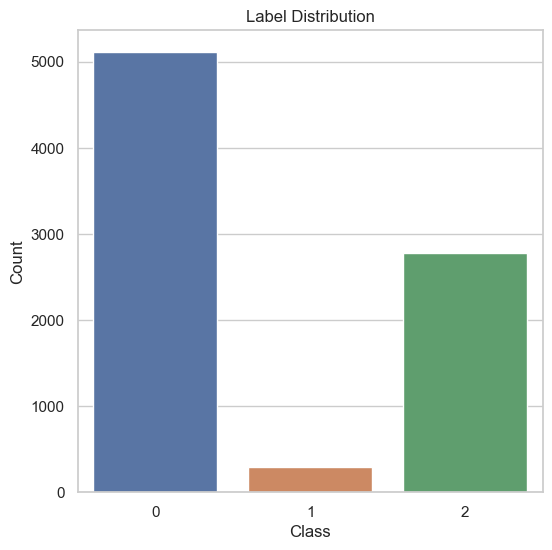

In [14]:
sns.set(style='whitegrid')
target_col = 'Status'
emission = train_data[target_col]
plt.figure(figsize=(6, 6))
sns.countplot(x='Status', data=train_data)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Label Distribution')
plt.show()

<font size="3">numerical feature distribution</font>

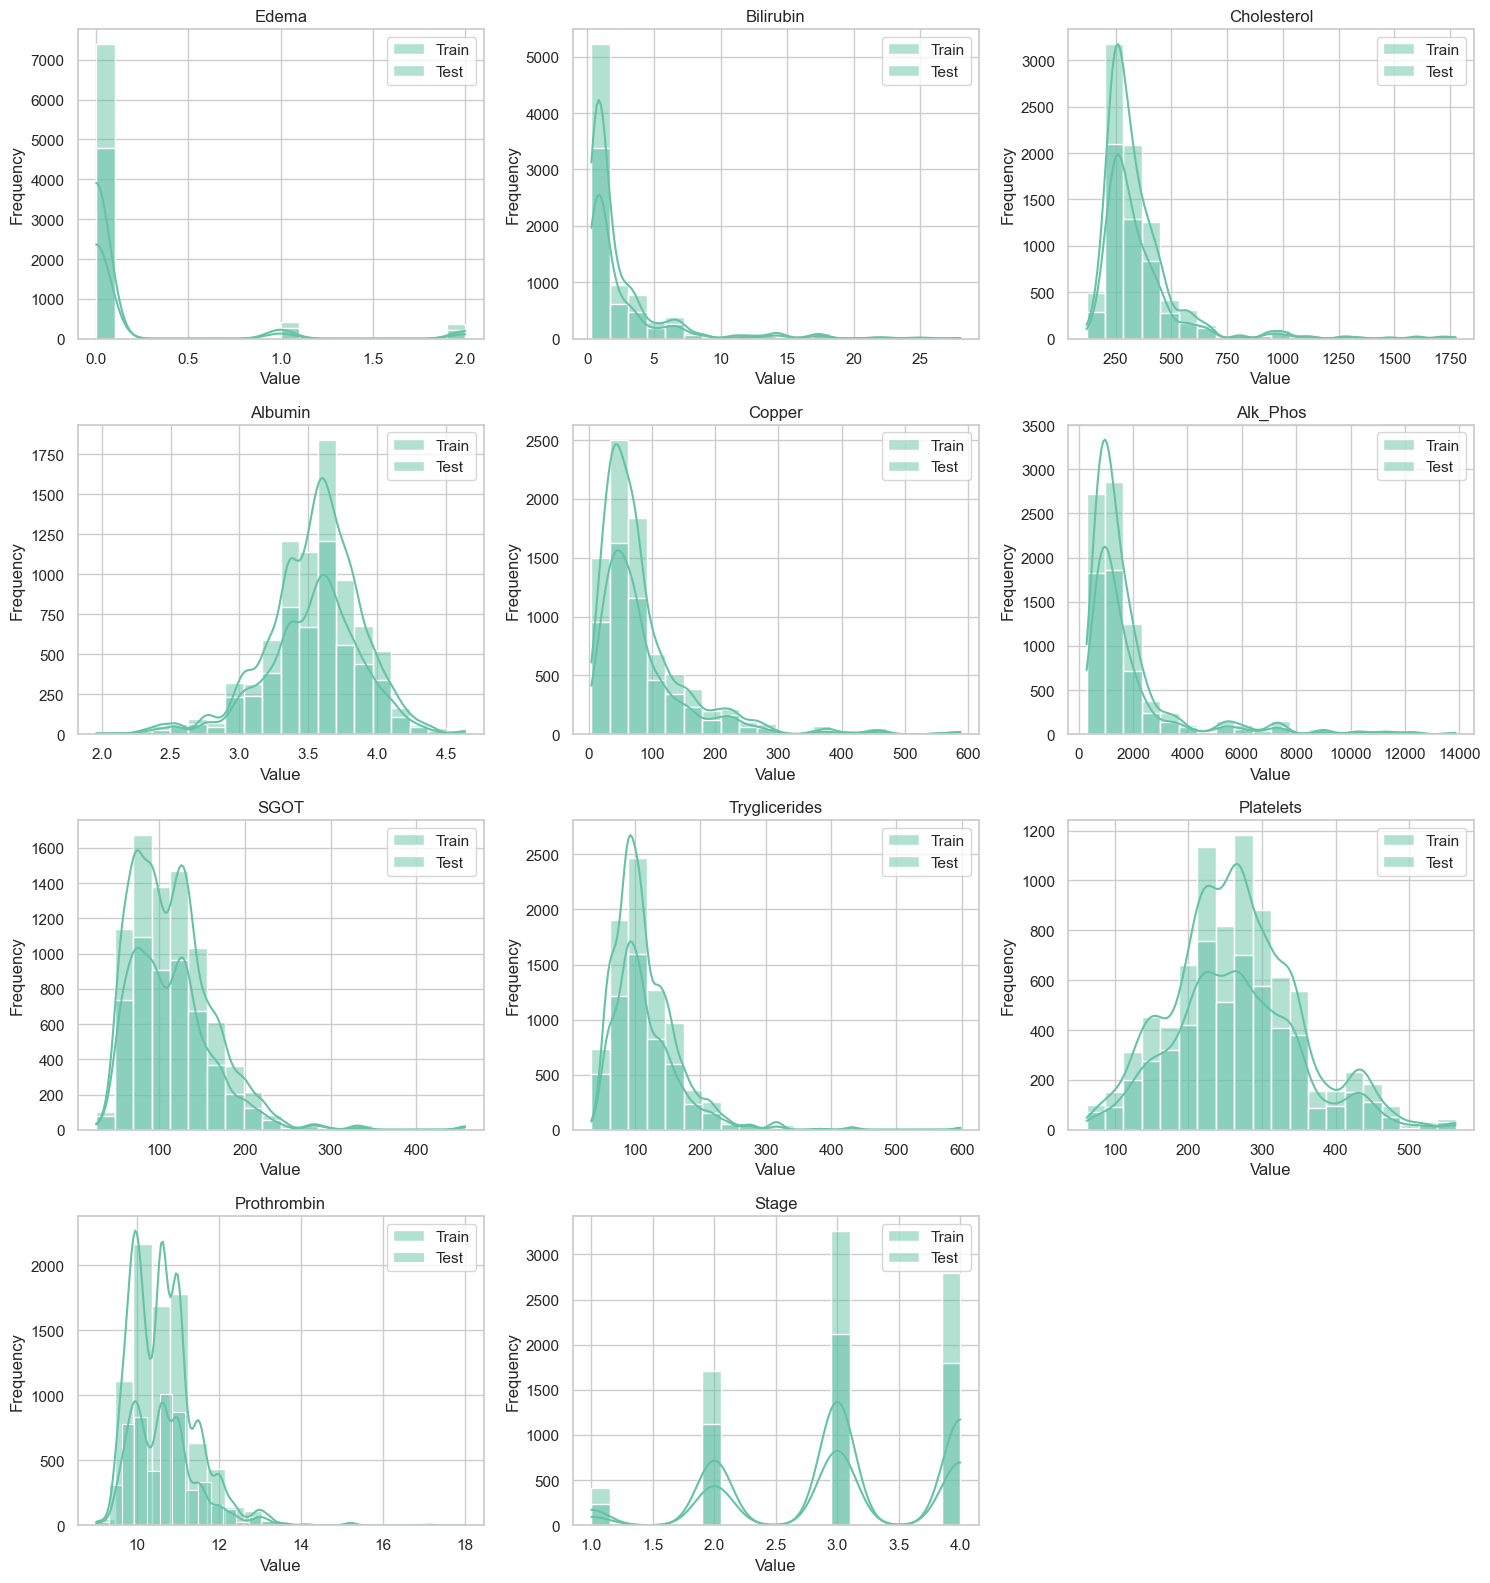

In [15]:
cont_cols = [f for f in train_data.columns if train_data[f].dtype in [float, int] and train_data[f].nunique()>2 and f not in [target_col]]
def num_feature_dist(train, test, label_col):
    sns.set_palette('Set2')

    num_rows = (len(cont_cols) + 2)//3
    fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*4))

    for i, col in enumerate(cont_cols):
        max_val = max(train[col].max(), test[col].max())
        min_val = min(train[col].min(), test[col].min())
        range_val = max_val - min_val

        bin_size = range_val / 20
        num_bins_train = round(range_val / bin_size)
        num_bins_test = round(range_val / bin_size)
        
        row = i // 3
        col_pos = i % 3

        sns.histplot(train[col], ax = axs[row][col_pos], kde=True, label='Train', bins=num_bins_train)
        sns.histplot(test[col], ax=axs[row][col_pos], kde=True, label='Test', bins=num_bins_test)
        
        axs[row][col_pos].set_title(col)
        axs[row][col_pos].set_xlabel('Value')
        axs[row][col_pos].set_ylabel('Frequency')
        axs[row][col_pos].legend()

    if len(cont_cols) % 3 != 0:
        for col_pos in range(len(cont_cols) % 3, 3):
            axs[-1][col_pos].remove()

    plt.tight_layout()
    plt.show()

num_feature_dist(train_data, test_data, label_col=target_col)

# 6. Feature Engineering

In [16]:
def min_max_scaler(train, test, column):
    '''
    Min Max just based on train might have an issue if test has extreme values, hence changing the denominator uding overall min and max
    '''
    sc=MinMaxScaler()
    
    max_val=max(train[column].max(),test[column].max())
    min_val=min(train[column].min(),test[column].min())

    train[column]=(train[column]-min_val)/(max_val-min_val)
    test[column]=(test[column]-min_val)/(max_val-min_val)
    
    return train,test  

def OHE(train_df,test_df,cols,target):
    '''
    Function for one hot encoding, it first combines the data so that no category is missed and
    the category with least frequency can be dropped because of redundancy
    '''
    combined = pd.concat([train_df, test_df], axis=0)
    for col in cols:
        one_hot = pd.get_dummies(combined[col])
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns=[str(f)+col+"_OHE" for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True,drop=True)
    test_ohe.drop(columns=[target],inplace=True)
    return train_ohe, test_ohe

device = 'CPU'
lgb_params = {
            'n_estimators': 100,
            'max_depth': 6,
            "num_leaves": 16,
            'learning_rate': 0.05,
            'subsample': 0.7,
            'colsample_bytree': 0.8,
            #'reg_alpha': 0.25,
            'reg_lambda': 5e-07,
            'objective': 'regression_l2',
            'metric': 'mean_squared_error',
            'boosting_type': 'gbdt',
            'random_state': 42,
            'device': device,
        }
def rmse(y1,y2):
    ''' Median Absolute Error Evaluator'''
    return(np.sqrt(mean_squared_error(np.array(y1),np.array(y2))))

def med_abs_error(y1,y2):
    ''' Median Absolute Error Evaluator'''
    return median_absolute_error(np.array(y1),np.array(y2))

def store_missing_rows(df, features):
    '''Function stores where missing values are located for given set of features'''
    missing_rows = {}
    
    for feature in features:
        missing_rows[feature] = df[df[feature].isnull()]
    
    return missing_rows

def fill_missing_numerical(train,test,target, max_iterations=10):
    '''Iterative Missing Imputer: Updates filled missing values iteratively using CatBoost Algorithm'''
    train_temp=train.copy()
    if target in train_temp.columns:
        train_temp=train_temp.drop(columns=target)
        
    
    df=pd.concat([train_temp,test],axis="rows")
    df=df.reset_index(drop=True)
    features=[ f for f in df.columns if df[f].isna().sum()>0]
    if len(features)>0:
        # Step 1: Store the instances with missing values in each feature
        missing_rows = store_missing_rows(df, features)

        # Step 2: Initially fill all missing values with "Missing"
        for f in features:
            df[f]=df[f].fillna(df[f].mean())

        cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
        dictionary = {feature: [] for feature in features}

        for iteration in tqdm(range(max_iterations), desc="Iterations"):
            for feature in features:
                # Skip features with no missing values
                rows_miss = missing_rows[feature].index

                missing_temp = df.loc[rows_miss].copy()
                non_missing_temp = df.drop(index=rows_miss).copy()
                y_pred_prev=missing_temp[feature]
                missing_temp = missing_temp.drop(columns=[feature])


                # Step 3: Use the remaining features to predict missing values using Random Forests
                X_train = non_missing_temp.drop(columns=[feature])
                y_train = non_missing_temp[[feature]]

                model = MultiOutputClassifier(XGBClassifier(tree_method='gpu_hist'))
                model.fit(X_train, y_train, verbose=False)

                # Step 4: Predict missing values for the feature and update all N features
                y_pred = model.predict(missing_temp)
                df.loc[rows_miss, feature] = y_pred
                #error_minimize=med_abs_error(y_pred,y_pred_prev)
                score_maximize = accuracy_score(y_pred, y_pred_prev)
                dictionary[feature].append(score_maximize)  # Append the error_minimize value

        train[features] = np.array(df.iloc[:train.shape[0]][features])
        test[features] = np.array(df.iloc[train.shape[0]:][features])

    return train,test

# 7. Feature Selection

In [17]:
def feature_selection_pca(train, test, label_col):
    final_drop_list=[]
    
    table = PrettyTable()
    table.field_names = ['Original', 'Final Transformation', 'LogLoss CV']
    threshold=0.95
    # It is possible that multiple parent features share same child features, so store selected features to avoid selecting the same feature again
    best_cols=[]
    
    for col in cont_cols:
        sub_set=[f for f in train.columns if col in f and train[f].nunique()>2]
    #     print(sub_set)
        if len(sub_set)>2:
            correlated_features = []
    
            for i, feature in enumerate(sub_set):
                # Check correlation with all remaining features
                for j in range(i+1, len(sub_set)):
                    correlation = np.abs(train[feature].corr(train[sub_set[j]]))
                    # If correlation is greater than threshold, add to list of highly correlated features
                    if correlation > threshold:
                        correlated_features.append(sub_set[j])
    
            # Remove duplicate features from the list
            correlated_features = list(set(correlated_features))
    #         print(correlated_features)
            if len(correlated_features)>=2:
    
                temp_train=train[correlated_features]
                temp_test=test[correlated_features]
                #Scale before applying PCA
                sc=StandardScaler()
                temp_train=sc.fit_transform(temp_train)
                temp_test=sc.transform(temp_test)
    
                # Initiate PCA
                pca=TruncatedSVD(n_components=1)
                x_pca_train=pca.fit_transform(temp_train)
                x_pca_test=pca.transform(temp_test)
                x_pca_train=pd.DataFrame(x_pca_train, columns=[col+"_pca_comb_final"])
                x_pca_test=pd.DataFrame(x_pca_test, columns=[col+"_pca_comb_final"])
                train=pd.concat([train,x_pca_train],axis='columns')
                test=pd.concat([test,x_pca_test],axis='columns')
    
                # Clustering
                model = KMeans()
                kmeans = KMeans(n_clusters=12)
                kmeans.fit(np.array(temp_train))
                labels_train = kmeans.labels_
    
                train[col+'_final_cluster'] = labels_train
                test[col+'_final_cluster'] = kmeans.predict(np.array(temp_test))
    
                correlated_features=correlated_features+[col+"_pca_comb_final",col+"_final_cluster"]
    
                # See which transformation along with the original is giving you the best univariate fit with target
                kf=KFold(n_splits=5, shuffle=True, random_state=42)
    
                scores=[]
    
                for f in correlated_features:
                    X=train[[f]].values
                    y=train[label_col].values
    
                    loss_list=[]
                    for train_idx, val_idx in kf.split(X,y):
                        X_train,y_train=X[train_idx],y[train_idx]
                        x_val,y_val=X[val_idx],y[val_idx]
    
                        model=LinearRegression()
                        model.fit(X_train, y_train)
                        y_pred = model.predict_proba(x_val)
                        cur_loss = log_loss(y_val, y_pred)
                        loss_list.append(cur_loss)
                    if f not in best_cols:
                        scores.append((f,np.mean(loss_list)))
                best_col, best_acc=sorted(scores, key=lambda x:x[1], reverse=False)[0]
                best_cols.append(best_col)
    
                cols_to_drop = [f for f in correlated_features if  f not in best_cols]
                if cols_to_drop:
                    final_drop_list=final_drop_list+cols_to_drop
                table.add_row([col,best_col ,best_acc])
    
    print(table)

feature_selection_pca(train_data, test_data, target_col)

+----------+----------------------+------------+
| Original | Final Transformation | LogLoss CV |
+----------+----------------------+------------+
+----------+----------------------+------------+


In [18]:
X_train = train_data.drop([target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data.copy()
print(X_train.shape, X_test.shape)

(8181, 18) (5271, 18)


# 8. Modeling

In [19]:
model_list = ['md1','md2','md3', 'md4']
def objective(trial, y_true, y_preds):
    params = {name:trial.suggest_int(name, 1, 100) for name in model_list}
    probs = sum([params[name]*y_preds[name] for name in model_list])/sum([params[name] for name in model_list])
    score = accuracy_score(y_true, probs)
    return score
X_train.info

<bound method DataFrame.info of       N_Days  Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  \
0        999     0  21532    1        0             0        0      0   
1       2574     1  19237    0        0             0        0      0   
2       3428     1  13727    0        0             1        1      2   
3       2576     1  18460    0        0             0        0      0   
4        788     1  16658    0        0             1        0      0   
...      ...   ...    ...  ...      ...           ...      ...    ...   
8176    1153     0  22347    0        0             1        0      0   
8177     994     1  21294    0        0             0        0      0   
8178     939     0  22767    0        0             0        0      0   
8179     839     0  13879    0        0             0        0      0   
8180     788     1  12109    0        0             0        1      0   

      Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  \
0         2.300      316

In [20]:
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
X_train_new = pd.DataFrame()
y_train_new = pd.DataFrame()
ens_cv_scores, ens_test_preds = list(), list()
n_trials = 500
random_state = 2023

sk = StratifiedKFold(n_splits = 5, shuffle = True, random_state = random_state)
for i, (train_idx, test_idx) in enumerate(sk.split(X_train, y_train)):
    X_tr, X_va = X_train.iloc[train_idx], X_train.iloc[test_idx]
    Y_tr, Y_va = y_train.iloc[train_idx], y_train.iloc[test_idx]
    
    lgbm_params={'random_state': 1819, 
                 'n_estimators': 309, 
                 'reg_alpha': 0.009043959900513852, 
                 'reg_lambda': 6.932606602460183, 
                 'colsample_bytree': 0.6183243994985523, 
                 'subsample': 0.6595851034943229, 
                 'learning_rate': 0.016870023802940223, 
                 'num_leaves': 50, 
                 'min_child_samples': 27}
    md_lgbm = LGBMClassifier(**lgbm_params).fit(X_tr, Y_tr)
    ##
    lgbm_params2 = {'n_estimators': 1000,
                    'learning_rate': 0.013657589160895923,
                    'max_depth': 17,
                    'reg_alpha': 1.9791969860931342,
                    'reg_lambda': 1.2857088172765347,
                    'num_leaves': 37,
                    'subsample': 0.6351453342675659,
                    'colsample_bytree': 0.2644509924064132}
    md_lgbm2 = LGBMClassifier(**lgbm_params2).fit(X_tr, Y_tr)
    ##
    xgb_params = {'max_depth': 7,
                  'learning_rate': 0.03570188608151033,
                  'n_estimators': 1000,
                  'gamma': 0.6440001307764849,
                  'min_child_weight': 2,
                  'colsample_bytree': 0.27034458854562116,
                  'subsample': 0.8435412915999765}
    md_xgb = XGBClassifier(**xgb_params).fit(X_tr, Y_tr)
    best_score = 0.0
    best_wei = 0.0
    for wei in np.arange(0.01, 1.0, 0.02):
        fold_pred = wei*md_lgbm.predict_proba(X_va) + (1.0-wei)*md_xgb.predict_proba(X_va)
        fold_score = log_loss(Y_va, fold_pred)
        if best_score > fold_score:
            best_score = fold_score
            best_wei = wei
    best_score2 = 0.0
    best_wei2 = 0.0
    for wei in np.arange(0.01, 1.0, 0.02):
        fold_pred = wei*(best_wei*md_lgbm.predict_proba(X_va) + (1.0-best_wei)*md_xgb.predict_proba(X_va))+(1.0-wei)*md_lgbm2.predict_proba(X_va)
        fold_score = log_loss(Y_va, fold_pred)
        if best_score2 > fold_score:
            best_score2 = fold_score
            best_wei2 = wei
    ens_cv_scores.append(best_wei2*best_score+(1.0-best_wei2)*best_score2)
    print('Fold', i, '==> Ensemble oof Log-loss score is ==>', best_wei2*best_score+(1.0-best_wei2)*best_score2)
    test_pred = best_wei2*(best_wei*md_lgbm.predict_proba(X_test)+(1.0-best_wei)*md_xgb.predict_proba(X_test))+(1.0-best_wei2)*md_lgbm2.predict_proba(X_test)
    ens_test_preds.append(test_pred)


ModuleNotFoundError: No module named 'catboost'

In [ ]:
print('final oof LogLoss score is', np.mean(ens_cv_scores))

In [ ]:
sub = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
res = np.mean(ens_test_preds, axis=0)
cols=['Status_C','Status_CL','Status_D']
sub[cols] = res
sub[cols]=sub[cols].div(sub[cols].sum(axis=1), axis=0)
sub.to_csv('submission.csv',index=False)
sub.head()